# Samples analysis
Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.1' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug, tree

from functools import partial
from getdist import plots
from numpyro import infer

%matplotlib inline
%load_ext autoreload
%autoreload 2

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

2024-12-16 12:21:52.735759: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Config and fiduc

In [76]:
def get_save_dir(**kwargs):
    # dir = os.path.expanduser("~/scratch/pickles/")
    dir = os.path.expanduser("/lustre/fsn1/projects/rech/fvg/uvs19wt/pickles/")

    dir += f"m{kwargs['mesh_shape'][0]:d}_b{kwargs['box_shape'][0]:.1f}"
    dir += f"_al{kwargs['a_lpt']:.1f}_ao{kwargs['a_obs']:.1f}_lo{kwargs['lpt_order']:d}_pc{kwargs['precond']:d}_ob{kwargs['obs']}/"
    return dir

def from_id(id):
    args = ParseSlurmId(id)
    config = {
          'mesh_shape':3 * (args.mesh_length,),
          'box_shape':3 * (args.box_length if args.box_length is not None else 5 * args.mesh_length,), 
          'a_lpt':args.a_obs if args.lpt_order > 0 else args.a_lpt,
          'a_obs':args.a_obs,
          'lpt_order':1 if args.lpt_order==1 else 2, # 2lpt + pm for 0
          'precond':args.precond,
          'obs':args.obs
          }
    save_dir = get_save_dir(**config)
    model = FieldLevelModel(**default_config | config)
    
    mcmc_config = {
        'sampler':"NUTS",
        'target_accept_prob':args.target_accept_prob,
        'n_samples':64,
        'max_tree_depth':10,
        'n_runs':10,
        'n_chains':8
    }
    save_path = save_dir 
    save_path += f"s{mcmc_config['sampler']}_nc{mcmc_config['n_chains']:d}_ns{mcmc_config['n_samples']:d}"
    save_path += f"_mt{mcmc_config['max_tree_depth']:d}_ta{mcmc_config['target_accept_prob']}"

    return model, mcmc_config, save_dir, save_path

class ParseSlurmId():
    def __init__(self, id):
        self.id = str(id)

        dic = {}
        dic['mesh_length'] = [32,64,128]
        dic['lpt_order'] = [0,1,2]
        dic['precond'] = [0,1,2,3]
        dic['target_accept_prob'] = [0.65, 0.8]

        dic['box_length'] = [None]
        dic['a_lpt'] = [0.1]
        dic['a_obs'] = [0.5]
        dic['obs'] = ['mesh']
        
        for i, (k, v) in enumerate(dic.items()):
            if i < len(self.id):
                setattr(self, k, v[int(self.id[i])])
            else:
                setattr(self, k, v[0])

In [77]:
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
task_id = 1120
model, mcmc_config, save_dir, save_path = from_id(task_id)

# os.makedirs(save_dir, exist_ok=True)
# import sys
# tempstdout = sys.stdout
# tempstderr = sys.stderr
# sys.stdout = open(save_path+'.out', 'a')
# sys.stderr = open(save_path+'.out', 'a')
# sys.stdout = tempstdout
# sys.stderr = tempstderr

In [ ]:
print(model)
# model.render()

if not os.path.exists(save_dir+"truth.p"):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir)    
    pdump(truth, save_dir+"truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.condition({'obs': truth['obs']})
model.obs_meshk = truth['obs']
model.block()
# model.render()

## Analysis

In [ ]:
from montecosmo.mcbench import Chains
task_id = 1120
model, mcmc_config, save_dir, save_path = from_id(task_id)

transforms = [partial(Chains.thin, thinning=1), 
              model.reparam_chains, 
              partial(Chains.choice, n=10)]
chains = model.load_runs(save_path, 2,10, transforms=transforms, batch_ndim=2)

last_state = pload(save_path + "_last_state.p")
print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)
chains.shape

In [22]:
shape = (2,20)
jfn = jit(partial(model.predict, samples=shape))
params = jfn(jr.key(42))
params |= {"n_evals":jnp.ones(shape)}
jnp.savez(save_dir + "samples_0", **params)
params = jfn(jr.key(43))
params |= {"n_evals":2*jnp.ones(shape)}
jnp.savez(save_dir + "samples_1", **params)
params = jfn(jr.key(44))
params |= {"n_evals":3*jnp.ones(shape)}
jnp.savez(save_dir + "samples_2", **params)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

In [67]:
from montecosmo.mcbench import Chains, Samples

transforms = [lambda x:x[['*~obs']], 
              partial(Chains.thin, thinning=None), 
              model.reparam_chains, 
              partial(Chains.choice, n=10)]
chains = model.load_runs(save_dir+"samples", 0,2, transforms=transforms, batch_ndim=2)
chains.shape

Loading: samples, from run 0 to run 2 (included)


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (2, 3),
 'b1': (2, 3),
 'b2': (2, 3),
 'bn2': (2, 3),
 'bs2': (2, 3),
 'init_mesh': (2, 3, 10),
 'n_evals': (2, 3),
 'sigma8': (2, 3)}

In [66]:
chains[['cosmo']]

Chains(data={'Omega_m': Array([[0.369221  , 0.17116699, 0.27259216],
       [0.22387749, 0.19053774, 0.12776649]], dtype=float32), 'sigma8': Array([[0.96338975, 1.2015287 , 1.064925  ],
       [0.77514017, 0.7416595 , 0.7175966 ]], dtype=float32)}, groups={'cosmo': ['Omega_m', 'sigma8'], 'bias': ['b1', 'b2', 'bs2', 'bn2'], 'init': ['init_mesh'], 'cosmo_': ['Omega_m_', 'sigma8_'], 'bias_': ['b1_', 'b2_', 'bs2_', 'bn2_'], 'init_': ['init_mesh_']}, labels={'Omega_m': '{\\Omega}_m', 'Omega_m_': '\\tilde{\\Omega}_m', 'sigma8': '{\\sigma}_8', 'sigma8_': '\\tilde{\\sigma}_8', 'b1': '{b}_1', 'b1_': '\\tilde{b}_1', 'b2': '{b}_2', 'b2_': '\\tilde{b}_2', 'bs2': '{b}_{s^2}', 'bs2_': '\\tilde{b}_{s^2}', 'bn2': '{b}_{\\nabla^2}', 'bn2_': '\\tilde{b}_{\\nabla^2}', 'init_mesh': '{\\delta}_L', 'init_mesh_': '\\tilde{\\delta}_L'})

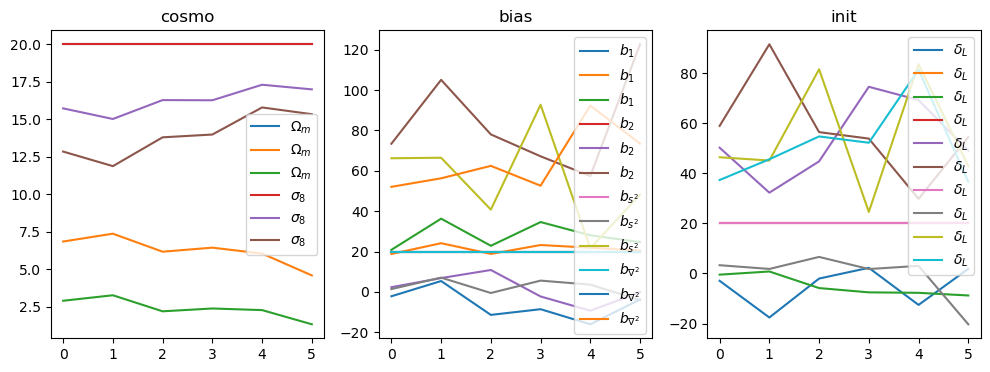

In [ ]:
plt.figure(figsize=(12,4))
chains.plot(['cosmo', 'bias','init'])
chains.print_summary()

Removed no burn in


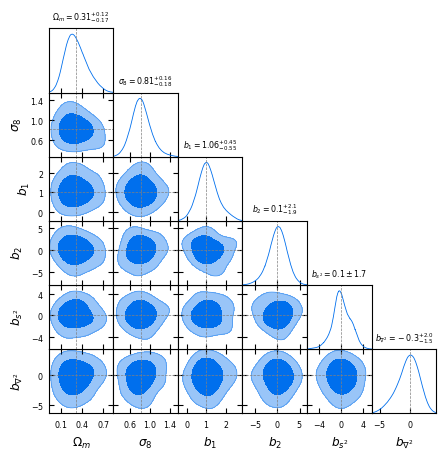

In [47]:
gdsamp = chains[['cosmo','bias']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,)

In [125]:
length = 10
aaa = jnp.arange(100).reshape(2,50)
n = 50

def cumfn_array(a, fn, n, *args, axis=0):
    filt_ends = jnp.rint(jnp.arange(1,n+1) / n * a.shape[axis]).astype(int)
    print(filt_ends)
    filt_fn = lambda end: fn(a[axis*(slice(None),) + (slice(None,end),)], *args)
    out = []
    for end in filt_ends:
        out.append(filt_fn(end))
    return jnp.stack(out, axis=axis)

def cumfn(chains, fn, n, *args, batch_ndim=2):
    axis = max(batch_ndim-1, 0)
    name = "n_evals"
    if name in chains:
        infos, rest = chains[[name], ['~'+name]]
        sum_fn = lambda x: cumfn_array(x, jnp.sum, n, axis=axis)
        infos = tree.map(sum_fn, infos)
    else:
        rest = chains
        infos = {}

    thin_fn = lambda x: cumfn_array(x, fn, n, *args, axis=axis)
    return infos | tree.map(thin_fn, rest)

cumfn_array(aaa, lambda x: jnp.sum(x, axis=1), n, axis=1), jnp.cumsum(aaa, axis=1), aaa

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


(Array([[   0,    1,    3,    6,   10,   15,   21,   28,   36,   45,   55,
           66,   78,   91,  105,  120,  136,  153,  171,  190,  210,  231,
          253,  276,  300,  325,  351,  378,  406,  435,  465,  496,  528,
          561,  595,  630,  666,  703,  741,  780,  820,  861,  903,  946,
          990, 1035, 1081, 1128, 1176, 1225],
        [  50,  101,  153,  206,  260,  315,  371,  428,  486,  545,  605,
          666,  728,  791,  855,  920,  986, 1053, 1121, 1190, 1260, 1331,
         1403, 1476, 1550, 1625, 1701, 1778, 1856, 1935, 2015, 2096, 2178,
         2261, 2345, 2430, 2516, 2603, 2691, 2780, 2870, 2961, 3053, 3146,
         3240, 3335, 3431, 3528, 3626, 3725]], dtype=int32),
 Array([[   0,    1,    3,    6,   10,   15,   21,   28,   36,   45,   55,
           66,   78,   91,  105,  120,  136,  153,  171,  190,  210,  231,
          253,  276,  300,  325,  351,  378,  406,  435,  465,  496,  528,
          561,  595,  630,  666,  703,  741,  780,  820,  861,  903,

In [71]:
def truc(a=1, b=2):
    print(a,b)

tree.map(truc, a=1, b=2)


TypeError: tree_map() got an unexpected keyword argument 'a'

In [53]:
jnp.rint(jnp.arange(1,n+1)/n*length).astype(int)

Array([2], dtype=int32)

In [ ]:
meshes = []
for pc in [0,1,2,3]:
    dir = get_save_dir(**model.__dict__ | {'precond':pc})
    # mesh = jnp.fft.irfftn(pload(dir + "truth.p")['init_mesh'])
    mesh = pload(dir + "truth.p")['obs']
    meshes.append(mesh)